In [1]:
import soundfile
import glob
import numpy as np
import filters
import scipy
import pickle
import ntpath
import os
from random import shuffle

import tensorflow as tf
import prettytensor as pt

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

%matplotlib inline

import matplotlib.pyplot as plt

/home/amit/workspace/learning_dp/.venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
prev_timestamp = 0
intervals_sec = 0.5

existsing_names = glob.glob("merged_files/*.wav")

if False:
    for f in sorted(glob.glob("soundfiles/*.wav")):
        timestamp = int(f.split("DT")[1].split(".")[0])
        diff_timestamp = timestamp - prev_timestamp
        if (diff_timestamp - 5000) < 10:
            samples, fs = soundfile.read(f)
            samples_prev, fs = soundfile.read(prev_f)
            merged = np.concatenate([samples_prev, samples])
            
            for i in range(100):
                if int(fs*intervals_sec)*(i+1)+samples.shape[0] > merged.shape[0]:
                    break
                filename = "merged_files/from_{}_{}_TS{}.wav".format(prev_timestamp, timestamp, int(fs*intervals_sec)*(i+1)+prev_timestamp)
                print filename
                if existsing_names.count(filename) == 1:
                    print "file exists"
                    break
                merged_cut = merged[int(fs*intervals_sec)*(i+1):int(fs*intervals_sec)*(i+1)+samples.shape[0],:]
                print filename
                soundfile.write(filename, merged_cut, fs)
                
            
        prev_f = f
        prev_timestamp = timestamp
        

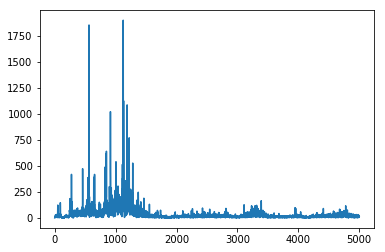

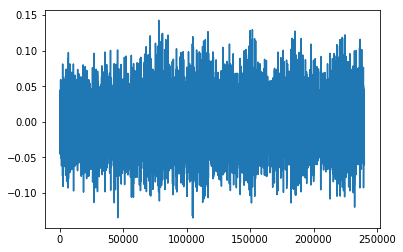

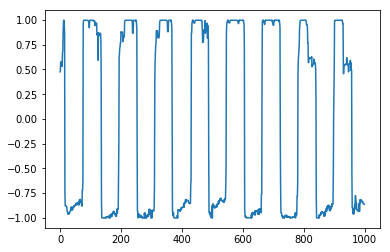

In [3]:
f = "soundfiles/V1_Srpi-lab-rec-001_DT1526572602090.wav"
def read_and_split(filepath):
    samples, fs = soundfile.read(filepath)
    samples = np.array(samples)
    sound_samples = samples[:, 0]
    sound_samples = sound_samples - np.mean(sound_samples)
    tach_samples = samples[:, 4]
    tach_samples = tach_samples - np.mean(tach_samples)
    tach_samples = scipy.signal.medfilt(tach_samples, kernel_size=[5])
    return sound_samples, tach_samples, fs
sound_samples, tach_samples, fs = read_and_split(f)
x = np.abs(np.fft.fft(sound_samples))
plt.plot(x[:len(x)/2][:5000])
plt.figure()

plt.plot(sound_samples)
plt.figure()
plt.plot(tach_samples[:1000])
plt.show()



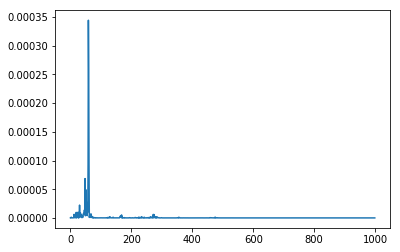

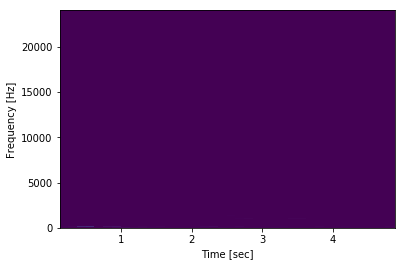

In [4]:
def calc_spectrogram(s, fs):
    f, t, Sxx = scipy.signal.spectrogram(s, fs=fs, nperseg=fs/4, noverlap = fs/8, scaling='spectrum')
    return f, t, Sxx
f, t, Sxx = calc_spectrogram(sound_samples, fs)
plt.plot(Sxx[:,0][:1000])
plt.figure()
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

The speed is  24.686192468619243


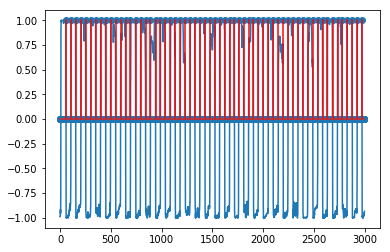

In [5]:
def calc_speed(tach_samples, fs, number_elements, samples_for_claculation=3000):
    tach_samples = tach_samples[-3000:-1]
    positive = np.where(tach_samples > 0)[0]
    positive_roll = np.roll(positive, 1)
    sub = positive - positive_roll
    sub[0] = 1
    cross_positive = positive[np.where(sub!=1)[0]]
    negative = np.where(tach_samples < 0)[0]
    negative_roll = np.roll(negative, 1)
    sub = negative - negative_roll
    sub[0] = 1
    cross_negative = negative[np.where(sub!=1)[0]]
    cross_vector = np.zeros(len(tach_samples))
    cross_vector[cross_positive] = 1
    cross_vector[cross_negative] = 1
    neg_pos_concat = np.concatenate((np.diff(cross_positive), np.diff(cross_negative)))
    speed = 1 / ((np.mean(neg_pos_concat)/ fs) * number_elements)
    return speed, tach_samples, cross_vector

number_elements = 20
speed, tach_samples_partial,cross_vector = calc_speed(tach_samples, fs, number_elements)

print "The speed is ", speed

plt.plot(tach_samples_partial)
plt.stem(cross_vector, 'r')
plt.show()

In [6]:
# converting and saving the data to pickle files

data_dict = {}
names = []
for f in glob.glob("*metadata*.pickle"):
    with open(f, 'rb') as handle:
        metadata = pickle.load(handle)
        names += metadata["names"]
        print "file {} has {} names".format(f, len(metadata["names"]))
idx = 0
spectrograms = {}
labels = {}
metadata = {}
new_name = []
idx = 0
print len(glob.glob("soundfiles/*.wav"))

org_files = glob.glob("soundfiles/*.wav")
merged_files = glob.glob("merged_files/*.wav")

all_files = org_files+merged_files
for _file in sorted(org_files+merged_files):
    idx += 1
    print _file, idx
    bn = ntpath.basename(_file)
    if names.count(bn) == 1:
        print "file exists. continue...."
        continue
    names.append(bn)
    sound_samples, tach_samples, fs = read_and_split(_file)
    f, t, Sxx = calc_spectrogram(sound_samples, fs)
    (speed, tach_samples_partial, cross_vector) = calc_speed(tach_samples, fs, 20)
    spectrograms[bn] = Sxx
    labels[bn] = speed
    new_name.append(bn)
    metadata["frequencies"] = f
    metadata["times"] = t
    if idx%100 == 0 or idx == len(all_files):
        dumpfile_name = "dumpfile_{}.pickle".format(idx)
        metadatafile_name = "dumpfile_{}_metadata.pickle".format(idx)
        print "saving to file {}".format(dumpfile_name)
        metadata["names"] = new_name
        data_dict = {"spectrograms": spectrograms, "labels": labels, "metadata": metadata}
        with open(dumpfile_name, 'wa') as handle:
            pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(metadatafile_name, 'wa') as handle:
            pickle.dump(metadata, handle, protocol=pickle.HIGHEST_PROTOCOL)
        spectrograms = {}
        labels = {}
        metadata = {}
        new_name = []

print "Finished"

file dumpfile_8555_metadata.pickle has 55 names
file dumpfile_2800_metadata.pickle has 100 names
file dumpfile_3200_metadata.pickle has 100 names
file dumpfile_500_metadata.pickle has 100 names
file dumpfile_800_metadata.pickle has 16 names
file dumpfile_2500_metadata.pickle has 100 names
file dumpfile_1100_metadata.pickle has 100 names
file dumpfile_6700_metadata.pickle has 100 names
file dumpfile_100_metadata.pickle has 100 names
file dumpfile_5100_metadata.pickle has 100 names
file dumpfile_5300_metadata.pickle has 100 names
file dumpfile_6600_metadata.pickle has 100 names
file dumpfile_7600_metadata.pickle has 100 names
file dumpfile_1700_metadata.pickle has 100 names
file dumpfile_7400_metadata.pickle has 100 names
file dumpfile_4600_metadata.pickle has 100 names
file dumpfile_1800_metadata.pickle has 100 names
file dumpfile_2100_metadata.pickle has 100 names
file dumpfile_8500_metadata.pickle has 100 names
file dumpfile_7000_metadata.pickle has 100 names
file dumpfile_1000_metada

merged_files/from_1526568807069_1526568812070_TS1526568831069.wav 171
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568855069.wav 172
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568879069.wav 173
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568903069.wav 174
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568927069.wav 175
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568951069.wav 176
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568975069.wav 177
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526568999069.wav 178
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526569023069.wav 179
file exists. continue....
merged_files/from_1526568807069_1526568812070_TS1526569047069.wav 180
file exists. continue....
merged_files/from_1526568812070_15265688

file exists. continue....
merged_files/from_1526569072079_1526569077082_TS1526569240079.wav 668
file exists. continue....
merged_files/from_1526569072079_1526569077082_TS1526569264079.wav 669
file exists. continue....
merged_files/from_1526569072079_1526569077082_TS1526569288079.wav 670
file exists. continue....
merged_files/from_1526569072079_1526569077082_TS1526569312079.wav 671
file exists. continue....
merged_files/from_1526569077082_1526569082087_TS1526569101082.wav 672
file exists. continue....
merged_files/from_1526569077082_1526569082087_TS1526569125082.wav 673
file exists. continue....
merged_files/from_1526569077082_1526569082087_TS1526569149082.wav 674
file exists. continue....
merged_files/from_1526569077082_1526569082087_TS1526569173082.wav 675
file exists. continue....
merged_files/from_1526569077082_1526569082087_TS1526569197082.wav 676
file exists. continue....
merged_files/from_1526569077082_1526569082087_TS1526569221082.wav 677
file exists. continue....
merged_files/f

merged_files/from_1526569382091_1526569387083_TS1526569574091.wav 1279
file exists. continue....
merged_files/from_1526569382091_1526569387083_TS1526569598091.wav 1280
file exists. continue....
merged_files/from_1526569382091_1526569387083_TS1526569622091.wav 1281
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569411083.wav 1282
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569435083.wav 1283
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569459083.wav 1284
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569483083.wav 1285
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569507083.wav 1286
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569531083.wav 1287
file exists. continue....
merged_files/from_1526569387083_1526569392084_TS1526569555083.wav 1288
file exists. continue....
merged_files/from_152656938708

file exists. continue....
merged_files/from_1526569652092_1526569657092_TS1526569868092.wav 1820
file exists. continue....
merged_files/from_1526569652092_1526569657092_TS1526569892092.wav 1821
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569681092.wav 1822
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569705092.wav 1823
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569729092.wav 1824
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569753092.wav 1825
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569777092.wav 1826
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569801092.wav 1827
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569825092.wav 1828
file exists. continue....
merged_files/from_1526569657092_1526569662090_TS1526569849092.wav 1829
file exists. continue....
merg

file exists. continue....
merged_files/from_1526569932100_1526569937098_TS1526570124100.wav 2379
file exists. continue....
merged_files/from_1526569932100_1526569937098_TS1526570148100.wav 2380
file exists. continue....
merged_files/from_1526569932100_1526569937098_TS1526570172100.wav 2381
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526569961098.wav 2382
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526569985098.wav 2383
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526570009098.wav 2384
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526570033098.wav 2385
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526570057098.wav 2386
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526570081098.wav 2387
file exists. continue....
merged_files/from_1526569937098_1526569942094_TS1526570105098.wav 2388
file exists. continue....
merg

merged_files/from_1526570217100_1526570222099_TS1526570289100.wav 2944
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570313100.wav 2945
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570337100.wav 2946
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570361100.wav 2947
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570385100.wav 2948
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570409100.wav 2949
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570433100.wav 2950
file exists. continue....
merged_files/from_1526570217100_1526570222099_TS1526570457100.wav 2951
file exists. continue....
merged_files/from_1526570222099_1526570227095_TS1526570246099.wav 2952
file exists. continue....
merged_files/from_1526570222099_1526570227095_TS1526570270099.wav 2953
file exists. continue....
merged_files/from_152657022209

file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570554094.wav 3474
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570578094.wav 3475
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570602094.wav 3476
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570626094.wav 3477
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570650094.wav 3478
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570674094.wav 3479
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570698094.wav 3480
file exists. continue....
merged_files/from_1526570482094_1526570487094_TS1526570722094.wav 3481
file exists. continue....
merged_files/from_1526570487094_1526570492092_TS1526570511094.wav 3482
file exists. continue....
merged_files/from_1526570487094_1526570492092_TS1526570535094.wav 3483
file exists. continue....
merg

merged_files/from_1526570732090_1526570737086_TS1526570804090.wav 3974
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570828090.wav 3975
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570852090.wav 3976
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570876090.wav 3977
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570900090.wav 3978
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570924090.wav 3979
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570948090.wav 3980
file exists. continue....
merged_files/from_1526570732090_1526570737086_TS1526570972090.wav 3981
file exists. continue....
merged_files/from_1526570737086_1526570742091_TS1526570761086.wav 3982
file exists. continue....
merged_files/from_1526570737086_1526570742091_TS1526570785086.wav 3983
file exists. continue....
merged_files/from_152657073708

merged_files/from_1526571022085_1526571027090_TS1526571142085.wav 4556
file exists. continue....
merged_files/from_1526571022085_1526571027090_TS1526571166085.wav 4557
file exists. continue....
merged_files/from_1526571022085_1526571027090_TS1526571190085.wav 4558
file exists. continue....
merged_files/from_1526571022085_1526571027090_TS1526571214085.wav 4559
file exists. continue....
merged_files/from_1526571022085_1526571027090_TS1526571238085.wav 4560
file exists. continue....
merged_files/from_1526571022085_1526571027090_TS1526571262085.wav 4561
file exists. continue....
merged_files/from_1526571027090_1526571032092_TS1526571051090.wav 4562
file exists. continue....
merged_files/from_1526571027090_1526571032092_TS1526571075090.wav 4563
file exists. continue....
merged_files/from_1526571027090_1526571032092_TS1526571099090.wav 4564
file exists. continue....
merged_files/from_1526571027090_1526571032092_TS1526571123090.wav 4565
file exists. continue....
merged_files/from_152657102709

file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571316092.wav 5092
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571340092.wav 5093
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571364092.wav 5094
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571388092.wav 5095
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571412092.wav 5096
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571436092.wav 5097
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571460092.wav 5098
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571484092.wav 5099
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571508092.wav 5100
file exists. continue....
merged_files/from_1526571292092_1526571297093_TS1526571532092.wav 5101
file exists. continue....
merg

merged_files/from_1526571552090_1526571557093_TS1526571672090.wav 5616
file exists. continue....
merged_files/from_1526571552090_1526571557093_TS1526571696090.wav 5617
file exists. continue....
merged_files/from_1526571552090_1526571557093_TS1526571720090.wav 5618
file exists. continue....
merged_files/from_1526571552090_1526571557093_TS1526571744090.wav 5619
file exists. continue....
merged_files/from_1526571552090_1526571557093_TS1526571768090.wav 5620
file exists. continue....
merged_files/from_1526571552090_1526571557093_TS1526571792090.wav 5621
file exists. continue....
merged_files/from_1526571557093_1526571562094_TS1526571581093.wav 5622
file exists. continue....
merged_files/from_1526571557093_1526571562094_TS1526571605093.wav 5623
file exists. continue....
merged_files/from_1526571557093_1526571562094_TS1526571629093.wav 5624
file exists. continue....
merged_files/from_1526571557093_1526571562094_TS1526571653093.wav 5625
file exists. continue....
merged_files/from_152657155709

merged_files/from_1526571802086_1526571807095_TS1526571922086.wav 6116
file exists. continue....
merged_files/from_1526571802086_1526571807095_TS1526571946086.wav 6117
file exists. continue....
merged_files/from_1526571802086_1526571807095_TS1526571970086.wav 6118
file exists. continue....
merged_files/from_1526571802086_1526571807095_TS1526571994086.wav 6119
file exists. continue....
merged_files/from_1526571802086_1526571807095_TS1526572018086.wav 6120
file exists. continue....
merged_files/from_1526571802086_1526571807095_TS1526572042086.wav 6121
file exists. continue....
merged_files/from_1526571807095_1526571812095_TS1526571831095.wav 6122
file exists. continue....
merged_files/from_1526571807095_1526571812095_TS1526571855095.wav 6123
file exists. continue....
merged_files/from_1526571807095_1526571812095_TS1526571879095.wav 6124
file exists. continue....
merged_files/from_1526571807095_1526571812095_TS1526571903095.wav 6125
file exists. continue....
merged_files/from_152657180709

file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572135093.wav 6683
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572159093.wav 6684
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572183093.wav 6685
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572207093.wav 6686
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572231093.wav 6687
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572255093.wav 6688
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572279093.wav 6689
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572303093.wav 6690
file exists. continue....
merged_files/from_1526572087093_1526572092093_TS1526572327093.wav 6691
file exists. continue....
merged_files/from_1526572092093_1526572097098_TS1526572116093.wav 6692
file exists. continue....
merg

file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572410098.wav 7233
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572434098.wav 7234
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572458098.wav 7235
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572482098.wav 7236
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572506098.wav 7237
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572530098.wav 7238
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572554098.wav 7239
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572578098.wav 7240
file exists. continue....
merged_files/from_1526572362098_1526572367094_TS1526572602098.wav 7241
file exists. continue....
merged_files/from_1526572367094_1526572372094_TS1526572391094.wav 7242
file exists. continue....
merg

soundfiles/V1_Srpi-lab-rec-001_DT1526568772072.wav 7782
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568777070.wav 7783
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568782072.wav 7784
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568787073.wav 7785
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568792066.wav 7786
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568797068.wav 7787
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568802075.wav 7788
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568807069.wav 7789
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568812070.wav 7790
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568817069.wav 7791
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568822074.wav 7792
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526568827066.wav 7793
file exists. continue....
soundfiles/V1_Sr

file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571892091.wav 8406
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571897096.wav 8407
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571902093.wav 8408
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571907093.wav 8409
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571912096.wav 8410
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571917095.wav 8411
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571922097.wav 8412
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571927089.wav 8413
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571932093.wav 8414
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571937090.wav 8415
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571942093.wav 8416
file exists. continue....
soundfiles/V1_Srpi-lab-rec-001_DT1526571947097.wav 8417
file exists. con

In [7]:
tf.__version__

'1.8.0'

In [8]:
batch_size = 50

In [9]:
names = []
datafiles = []
metadatafiles = glob.glob("*metadata*.pickle")

data_files_counter = 0
for f in sorted(metadatafiles):
    temp_split = f.split("_metadata")
    datafiles.append("{}{}".format(temp_split[0], temp_split[1]))
    data_files_counter += 1
    with open(f, 'rb') as handle:
        metadata = pickle.load(handle)
        names += metadata["names"]
#         print "file {} has {} names".format(f, len(metadata["names"]))


names = shuffle(names)
training_pickles = datafiles[:int(len(datafiles)*0.6)]
validation_pickles = datafiles[:int(len(datafiles)*0.2)]
test_pickles = datafiles[:int(len(datafiles)*0.2)]

print len(training_pickles)
print len(validation_pickles)
print len(test_pickles)

with open(training_pickles[0], 'rb') as handle:
    data = pickle.load(handle)
    spectrogram_shape = data['spectrograms'][data['spectrograms'].keys()[0]].shape
    img_shape_full = (batch_size, int(spectrogram_shape[0]), int(spectrogram_shape[1]),1)
    
print img_shape_full



52
17
17
(50, 6001, 39, 1)


In [10]:
def batch_generator(batch_size, spectrogram_shape, pickle_files_list):
    """
    Generator function for creating random batches of training-data.
    """
    files_idx = 0
    with open(pickle_files_list[files_idx], 'rb') as handle:
        data = pickle.load(handle)
        spectrograms = data['spectrograms']
        labels = data['labels']
        files_idx += 1 
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_batch = []
        y_batch = []
        # Fill the batch with random sequences of data.
        while len(x_batch) < batch_size:
            key = spectrograms.keys()[-1]
            s = spectrograms.pop(key)
            l = labels.pop(key)
            if s.shape[0] != spectrogram_shape[0] or s.shape[1] != spectrogram_shape[1]:
                print "unmatch dimesions {} {} ".format(s.shape, spectrogram_shape)
                continue
            x_batch.append(s)
            y_batch.append(l)
            if len(spectrograms) == 0:
                files_idx = files_idx % len(pickle_files_list)
                with open(pickle_files_list[files_idx], 'rb') as handle:
                    data = pickle.load(handle)
                    spectrograms = data['spectrograms']
                    labels = data['labels']
                    files_idx += 1 
                
            
        x_batch = np.expand_dims(x_batch, axis=3)
        yield (np.array(x_batch), np.array(y_batch))
        

In [11]:

generator = batch_generator(batch_size=batch_size,
                            spectrogram_shape=spectrogram_shape, pickle_files_list=training_pickles)

In [12]:
if False:
    for i in range(50):
        x_batch, y_batch = next(generator)
        print "X"

    print x_batch.shape
    print y_batch.shape

In [13]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(batch_input_shape=img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=5, strides=5))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=5, strides=5))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# # First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(1, activation='relu'))

In [14]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

In [15]:
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [16]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

path_checkpoint = 'keras'
checkpointer = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_best_only=True)

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callbacks = [
    callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr
]

Epoch 1/20
 23/100 [=====>........................] - ETA: 1:36 - loss: 240.2594 - acc: 0.0000e+00unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 128s 1s/step - loss: 67.8874 - acc: 0.0000e+00


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

Epoch 2/20
 27/100 [=======>......................] - ETA: 1:20 - loss: 21.6778 - acc: 0.0000e+00unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 19.3711 - acc: 0.0000e+00
Epoch 3/20
  1/100 [..............................] - ETA: 14s - loss: 9.9010 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 31/100 [========>.....................] - ETA: 1:21 - loss: 21.7465 - acc: 0.0000e+00unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 128s 1s/step - loss: 19.7817 - acc: 0.0000e+00
Epoch 4/20
  1/100 [..............................] - ETA: 13s - loss: 10.8286 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 35/100 [=========>....................] - ETA: 1:16 - loss: 20.9212 - acc: 0.0000e+00unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 124s 1s/step - loss: 19.0580 - acc: 0.0000e+00
Epoch 5/20
  1/100 [..............................] - ETA: 13s - loss: 35.8061 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 39/100 [==========>...................] - ETA: 1:11 - loss: 21.2335 - acc: 5.1282e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 122s 1s/step - loss: 18.8225 - acc: 2.0000e-04
Epoch 6/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 42/100 [===========>..................] - ETA: 1:10 - loss: 20.8099 - acc: 4.7619e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 18.0294 - acc: 2.0000e-04
Epoch 7/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 46/100 [============>.................] - ETA: 1:05 - loss: 20.0277 - acc: 8.6957e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 124s 1s/step - loss: 17.3666 - acc: 4.0000e-04
Epoch 8/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 50/100 [==============>...............] - ETA: 1:01 - loss: 18.5192 - acc: 4.0000e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 124s 1s/step - loss: 16.5688 - acc: 2.0000e-04
Epoch 9/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 54/100 [===============>..............] - ETA: 56s - loss: 17.4318 - acc: 3.7037e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 16.3018 - acc: 2.0000e-04
Epoch 10/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 58/100 [================>.............] - ETA: 51s - loss: 16.4357 - acc: 6.8966e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 127s 1s/step - loss: 15.9943 - acc: 4.0000e-04
Epoch 11/20
  1/100 [..............................] - ETA: 14s - loss: 13.4112 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 61/100 [=================>............] - ETA: 47s - loss: 16.1775 - acc: 6.5574e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 126s 1s/step - loss: 16.1701 - acc: 4.0000e-04
Epoch 12/20
  1/100 [..............................] - ETA: 13s - loss: 5.8379 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 65/100 [==================>...........] - ETA: 42s - loss: 15.4077 - acc: 6.1538e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 15.6579 - acc: 4.0000e-04
Epoch 13/20
  1/100 [..............................] - ETA: 14s - loss: 25.3809 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 69/100 [===================>..........] - ETA: 37s - loss: 15.4051 - acc: 5.7971e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 124s 1s/step - loss: 15.6271 - acc: 4.0000e-04
Epoch 14/20
  1/100 [..............................] - ETA: 13s - loss: 21.3562 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 73/100 [====================>.........] - ETA: 32s - loss: 15.4651 - acc: 5.4795e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 15.4884 - acc: 4.0000e-04
Epoch 15/20
  1/100 [..............................] - ETA: 13s - loss: 22.9237 - acc: 0.0000e+00

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 77/100 [======================>.......] - ETA: 27s - loss: 15.7406 - acc: 5.1948e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 124s 1s/step - loss: 15.1305 - acc: 4.0000e-04
Epoch 16/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 80/100 [=======================>......] - ETA: 24s - loss: 16.6299 - acc: 5.0000e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 15.9281 - acc: 4.0000e-04
Epoch 17/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 84/100 [========================>.....] - ETA: 19s - loss: 16.3060 - acc: 4.7619e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 125s 1s/step - loss: 16.1184 - acc: 4.0000e-04
Epoch 18/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 88/100 [=========================>....] - ETA: 14s - loss: 15.6711 - acc: 4.5455e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 124s 1s/step - loss: 15.5524 - acc: 4.0000e-04
Epoch 19/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 92/100 [==========================>...] - ETA: 9s - loss: 15.7761 - acc: 4.3478e-04 unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 123s 1s/step - loss: 15.8951 - acc: 4.0000e-04
Epoch 20/20


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

 96/100 [===========================>..] - ETA: 4s - loss: 15.5423 - acc: 4.1667e-04unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
unmatch dimesions (6001, 4) (6001, 39) 
100/100 [==============================] - 125s 1s/step - loss: 15.7098 - acc: 4.0000e-04


Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 126
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not 

Saved model to disk


KeyError: 'val_acc'

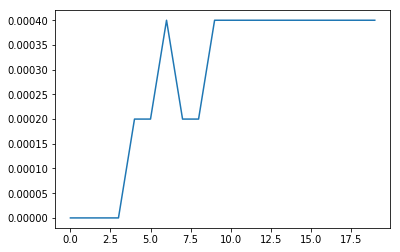

In [17]:
history = model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    callbacks=callbacks
                   )

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")